<a href="https://colab.research.google.com/github/pdangi-web/Data_Mining_HW/blob/main/HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet scikit-surprise pandas matplotlib numpy scikit-learn reportlab tqdm

In [2]:
!pip install numpy==1.26.4
!pip install scikit-surprise==1.1.3

import numpy as np
import surprise
print("NumPy Version:", np.__version__)
print("Surprise Version:", surprise.__version__)


  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp312-cp312-linux_x86_64.whl size=3513891 sha256=01b5924f5d9a110df41aecd7eecfdac77dd46f500fc044da606741c6129d0a42
  Stored in directory: /root/.cache/pip/wheels/ee/08/67/4176eedbed1c63c15db21a526f1893ca43ee8453182a239afc
Successfully built scikit-surprise
  Attempting uninstall: scikit-surprise
    Found existing installation: scikit-surprise 1.1.4
    Uninstalling scikit-surprise-1.1.4:
      Successfully uninstalled scikit-surprise-1.1.4
NumPy Version: 1.26.4
Surprise Version: 1.1.3


In [3]:
import os, math, time, random
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
from surprise import Dataset, Reader, KNNBasic
from surprise import PredictionImpossible
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table
from reportlab.lib.styles import getSampleStyleSheet


RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
RATINGS_FILE = 'ratings_small.csv'
if not os.path.exists(RATINGS_FILE):
  raise FileNotFoundError(f"{RATINGS_FILE} not found. Upload it to the Colab working directory first.")


ratings_df = pd.read_csv(RATINGS_FILE)
expected_cols = ['userId','movieId','rating']
if set(expected_cols).issubset(ratings_df.columns):
  ratings_df = ratings_df[['userId','movieId','rating']]
else:
  raise ValueError('ratings_small.csv must contain columns: userId,movieId,rating (and optionally timestamp).')


ratings_df.columns = ['user','item','rating']
print('Loaded ratings:', ratings_df.shape)


user_ids = ratings_df['user'].unique()
item_ids = ratings_df['item'].unique()
user2index = {u:i for i,u in enumerate(user_ids)}
item2index = {i_:j for j,i_ in enumerate(item_ids)}
ratings_df['u_idx'] = ratings_df['user'].map(user2index)
ratings_df['i_idx'] = ratings_df['item'].map(item2index)
num_users = len(user_ids)
num_items = len(item_ids)
print('num_users', num_users, 'num_items', num_items)

Loaded ratings: (100004, 3)
num_users 671 num_items 9066


In [5]:
def mae(preds, trues):
  preds = np.array(preds); trues = np.array(trues)
  return np.mean(np.abs(preds-trues))


def rmse(preds, trues):
  preds = np.array(preds); trues = np.array(trues)
  return np.sqrt(np.mean((preds-trues)**2))

In [6]:


def pmf_sgd_train_predict(train_df, test_df, num_users, num_items, num_factors=20, lr=0.005, reg=0.02, n_epochs=20, clip=True, verbose=False):
  U = 0.1 * np.random.randn(num_users, num_factors)
  V = 0.1 * np.random.randn(num_items, num_factors)
  train_records = train_df[['u_idx','i_idx','rating']].values.copy()
  for epoch in range(n_epochs):
    np.random.shuffle(train_records)
    total_loss = 0.0
    for u,i,r in train_records:
      u = int(u); i = int(i)
      pred = U[u].dot(V[i])
      err = (r - pred)
      total_loss += err*err
      U[u] += lr * (err * V[i] - reg * U[u])
      V[i] += lr * (err * U[u] - reg * V[i])
    if verbose:
      print(f'PMF epoch {epoch+1}/{n_epochs} loss={total_loss:.4f}')
  preds = []
  trues = []
  for _, row in test_df.iterrows():
    u = int(row['u_idx']); i = int(row['i_idx']); r = row['rating']
    pred = U[u].dot(V[i])
    if clip:
      pred = min(5.0, max(1.0, pred))
    preds.append(pred); trues.append(r)
  return preds, trues

In [7]:


def surprise_knn_predict(train_df, test_df, user_based=True, sim_metric='cosine', k=20):
  reader = Reader(rating_scale=(1,5))
  data = Dataset.load_from_df(train_df[['user','item','rating']], reader)
  trainset = data.build_full_trainset()
  sim_options = {'name': sim_metric, 'user_based': user_based}
  algo = KNNBasic(k=k, min_k=1, sim_options=sim_options)
  algo.fit(trainset)
  preds = []
  trues = []
  for _, row in test_df.iterrows():
    uid = row['user']; iid = row['item']; r = row['rating']
    try:
      est = algo.predict(uid, iid).est
    except PredictionImpossible:
      est = trainset.global_mean
    est = float(est)
    est = min(5.0, max(1.0, est))
    preds.append(est); trues.append(r)
  return preds, trues

In [8]:


def run_experiments(ratings_df, num_users, num_items, n_splits=5,
                    similarities=['cosine','msd','pearson'],
                    k_values=[5,10,20,40],
                    pmf_params={'num_factors':20,'lr':0.005,'reg':0.02,'n_epochs':15}):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
  results = []
  fold = 0
  for train_idx, test_idx in kf.split(ratings_df):
    fold += 1
    print(f'Fold {fold}/{n_splits}')
    train_df = ratings_df.iloc[train_idx].reset_index(drop=True)
    test_df = ratings_df.iloc[test_idx].reset_index(drop=True)
    pmf_preds, pmf_trues = pmf_sgd_train_predict(train_df, test_df, num_users, num_items,
                                                 num_factors=pmf_params['num_factors'],
                                                 lr=pmf_params['lr'], reg=pmf_params['reg'],
                                                 n_epochs=pmf_params['n_epochs'])
    pmf_mae = mae(pmf_preds, pmf_trues)
    pmf_rmse = rmse(pmf_preds, pmf_trues)
    results.append({'fold':fold,'algo':'PMF','sim':'-','K':-1,'MAE':pmf_mae,'RMSE':pmf_rmse})
    print(f' PMF MAE={pmf_mae:.4f}, RMSE={pmf_rmse:.4f}')
    for sim in similarities:
      for k in k_values:
        try:
          u_preds, u_trues = surprise_knn_predict(train_df, test_df, user_based=True, sim_metric=sim, k=k)
          u_mae = mae(u_preds,u_trues); u_rmse = rmse(u_preds,u_trues)
        except Exception as e:
          print('UserCF error', e); u_mae = u_rmse = float('nan')
        results.append({'fold':fold,'algo':'UserCF','sim':sim,'K':k,'MAE':u_mae,'RMSE':u_rmse})
        try:
          i_preds, i_trues = surprise_knn_predict(train_df, test_df, user_based=False, sim_metric=sim, k=k)
          i_mae = mae(i_preds,i_trues); i_rmse = rmse(i_preds,i_trues)
        except Exception as e:
          print('ItemCF error', e); i_mae = i_rmse = float('nan')
        results.append({'fold':fold,'algo':'ItemCF','sim':sim,'K':k,'MAE':i_mae,'RMSE':i_rmse})
        print(f' sim={sim} K={k} -> User RMSE={u_rmse:.4f} | Item RMSE={i_rmse:.4f}')
  results_df = pd.DataFrame(results)
  agg = results_df.groupby(['algo','sim','K']).agg({'MAE':'mean','RMSE':'mean','fold':'count'}).reset_index()
  agg = agg.rename(columns={'fold':'folds_count'})
  return results_df, agg

In [11]:
# =========================
# Cell 8 (UPDATED): Full plotting suite for Option C
# =========================
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

# ---- (e) Similarity impact plot ----
def plot_similarity_impact(agg_df, savepath='similarity_impact.png'):
    sims = ['cosine','msd','pearson']
    plt.figure(figsize=(8,5))

    for algo, marker in [('UserCF','o'), ('ItemCF','s')]:
        subset = agg_df[agg_df['algo']==algo]
        means = [subset[subset['sim']==s]['RMSE'].mean() for s in sims]
        plt.plot(sims, means, marker=marker, linewidth=2, label=f"{algo}")

    plt.title("Impact of Similarity Metric on RMSE")
    plt.xlabel("Similarity Metric")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    display(plt.gcf())
    plt.show()
    print("Saved", savepath)


# ---- (f) UserCF K impact ----
def plot_k_user(agg_df, k_values, savepath='usercf_k_impact.png'):
    plt.figure(figsize=(8,5))
    subset = agg_df[agg_df['algo']=='UserCF']
    rmses = [subset[subset['K']==k]['RMSE'].mean() for k in k_values]

    plt.plot(k_values, rmses, marker='o', linewidth=2, label="UserCF RMSE")
    plt.title("User-based CF: RMSE vs Number of Neighbors K")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    display(plt.gcf())
    plt.show()
    print("Saved", savepath)


# ---- (f) ItemCF K impact ----
def plot_k_item(agg_df, k_values, savepath='itemcf_k_impact.png'):
    plt.figure(figsize=(8,5))
    subset = agg_df[agg_df['algo']=='ItemCF']
    rmses = [subset[subset['K']==k]['RMSE'].mean() for k in k_values]

    plt.plot(k_values, rmses, marker='s', linewidth=2, label="ItemCF RMSE")
    plt.title("Item-based CF: RMSE vs Number of Neighbors K")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    display(plt.gcf())
    plt.show()
    print("Saved", savepath)


# ---- (f) Combined K impact ----
def plot_k_combined(agg_df, k_values, savepath='k_neighbors_combined.png'):
    plt.figure(figsize=(8,5))

    # UserCF
    user_subset = agg_df[agg_df['algo']=='UserCF']
    user_rmses = [user_subset[user_subset['K']==k]['RMSE'].mean() for k in k_values]
    plt.plot(k_values, user_rmses, marker='o', linewidth=2, label="UserCF RMSE")

    # ItemCF
    item_subset = agg_df[agg_df['algo']=='ItemCF']
    item_rmses = [item_subset[item_subset['K']==k]['RMSE'].mean() for k in k_values]
    plt.plot(k_values, item_rmses, marker='s', linewidth=2, label="ItemCF RMSE")

    plt.title("User vs Item CF: RMSE vs Number of Neighbors K")
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    display(plt.gcf())
    plt.show()
    print("Saved", savepath)


In [10]:
class KMeansScratch:
  def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.tol = tol
    self.random_state = random_state
  def fit(self, X):
    if self.random_state is not None:
      np.random.seed(self.random_state)
    n_samples = X.shape[0]
    idx = np.random.choice(n_samples, self.n_clusters, replace=False)
    centroids = X[idx].astype(float)
    for it in range(self.max_iter):
      dists = np.linalg.norm(X[:,None,:] - centroids[None,:,:], axis=2)
      labels = np.argmin(dists, axis=1)
      new_centroids = np.array([X[labels==k].mean(axis=0) if np.any(labels==k) else centroids[k] for k in range(self.n_clusters)])
      shift = np.linalg.norm(new_centroids-centroids)
      centroids = new_centroids
      if shift <= self.tol:
        break
    self.cluster_centers_ = centroids
    self.labels_ = labels
    return self
  def predict(self, X):
    dists = np.linalg.norm(X[:,None,:] - self.cluster_centers_[None,:,:], axis=2)
    return np.argmin(dists, axis=1)

In [12]:
SIMILARITIES = ['cosine','msd','pearson']
K_VALUES = [5,10,20,40]
PMF_PARAMS = {'num_factors':20,'lr':0.005,'reg':0.02,'n_epochs':12}


start = time.time()
results_df, agg_df = run_experiments(ratings_df, num_users, num_items, n_splits=5,
similarities=SIMILARITIES, k_values=K_VALUES,
pmf_params=PMF_PARAMS)
print('Total experiment time (s):', time.time()-start)
results_df.to_csv('results_raw.csv', index=False)
agg_df.to_csv('results_summary.csv', index=False)

Fold 1/5
 PMF MAE=0.8480, RMSE=1.1271
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
 sim=cosine K=5 -> User RMSE=1.0418 | Item RMSE=1.1204
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
 sim=cosine K=10 -> User RMSE=1.0079 | Item RMSE=1.0653
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
 sim=cosine K=20 -> User RMSE=0.9962 | Item RMSE=1.0268
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
 sim=cosine K=40 -> User RMSE=0.9935 | Item RMSE=0.9995
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simi

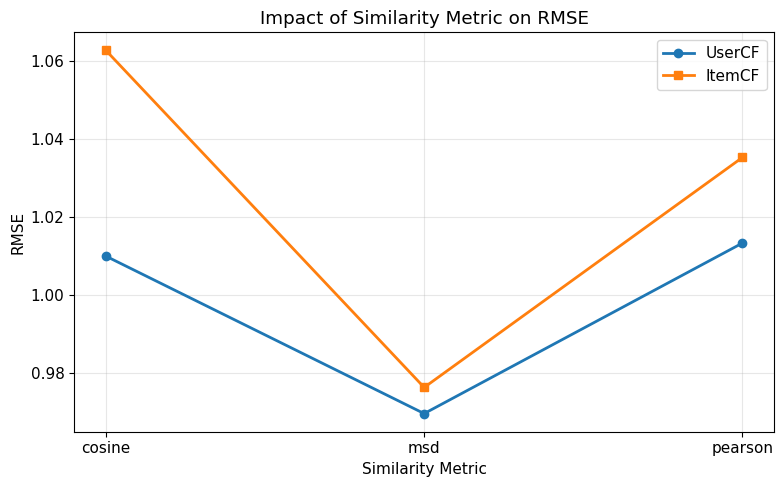

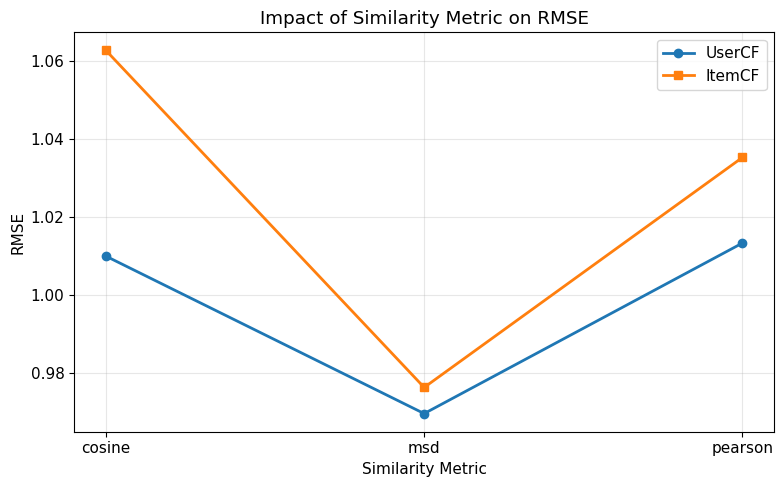

Saved similarity_impact.png


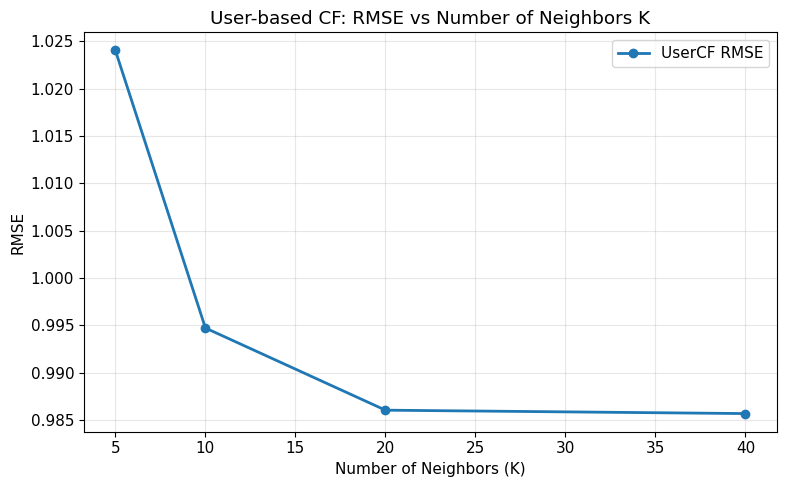

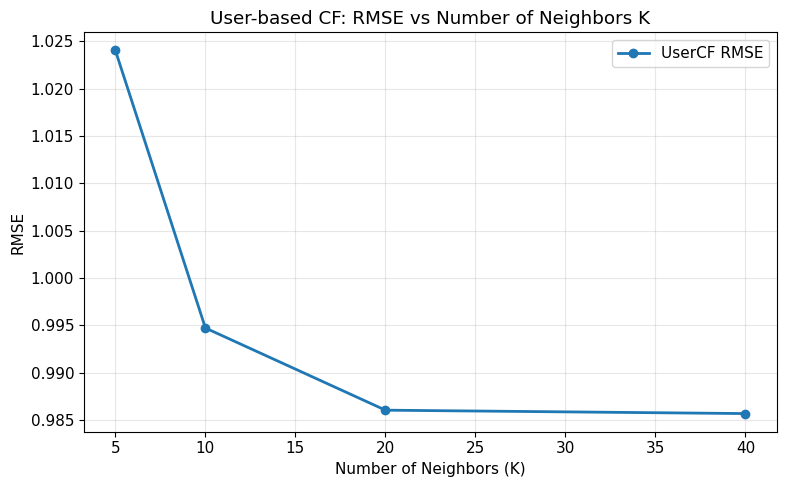

Saved usercf_k_impact.png


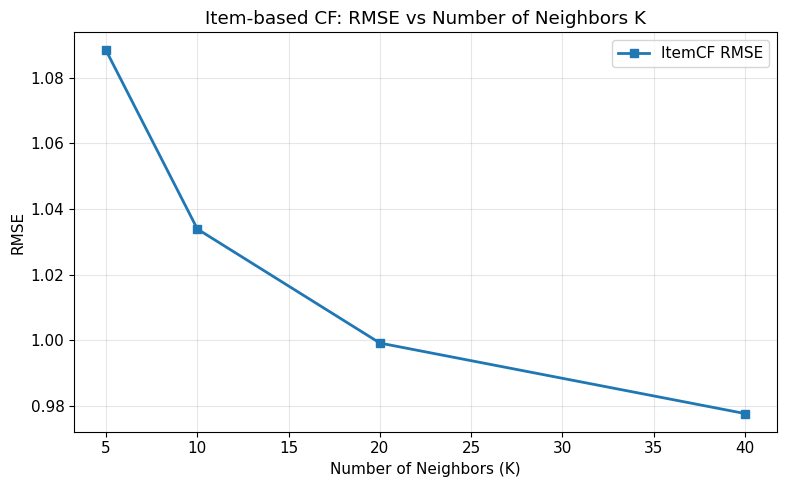

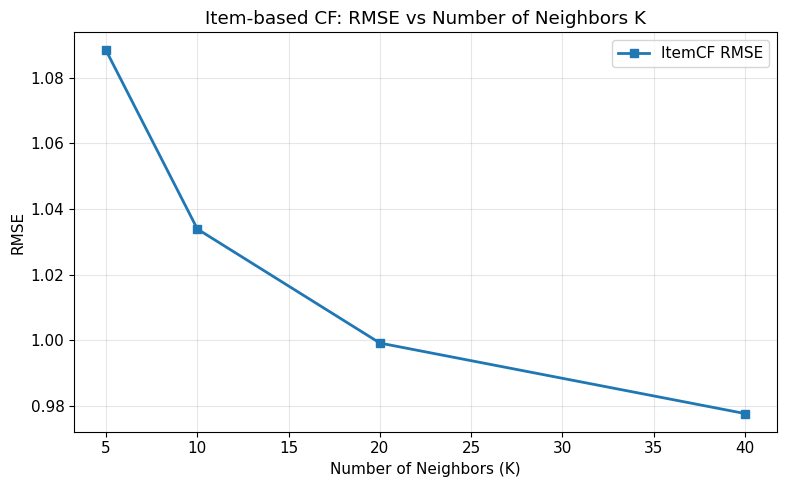

Saved itemcf_k_impact.png


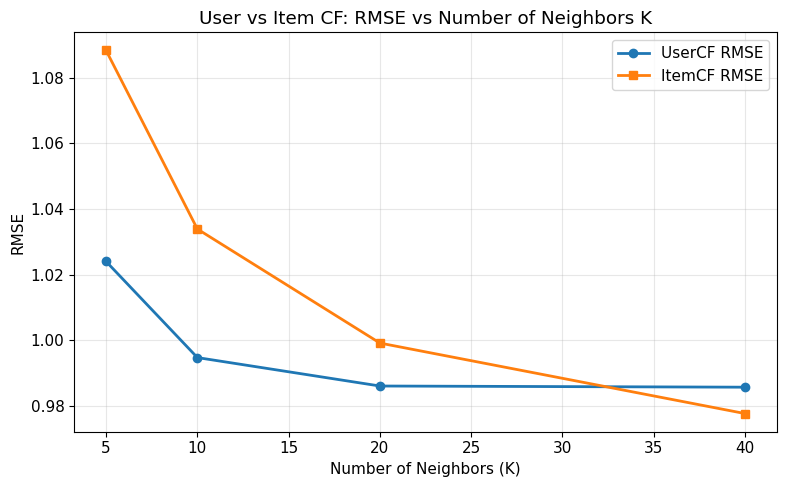

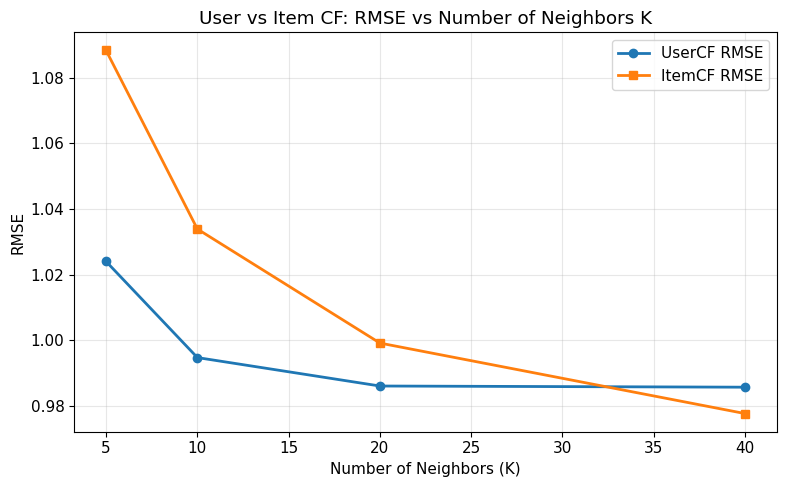

Saved k_neighbors_combined.png


In [13]:
# (e) Similarity impact
plot_similarity_impact(agg_df, savepath='similarity_impact.png')

# (f) K impact — 3 plots
plot_k_user(agg_df, K_VALUES, savepath='usercf_k_impact.png')
plot_k_item(agg_df, K_VALUES, savepath='itemcf_k_impact.png')
plot_k_combined(agg_df, K_VALUES, savepath='k_neighbors_combined.png')


In [15]:
sim_table = agg_df[['sim','algo','RMSE','MAE']].copy()
sim_table = sim_table.sort_values(['sim','algo'])
print("\n=== Similarity Performance Matrix ===\n")
print(sim_table.to_string(index=False))



=== Similarity Performance Matrix ===

    sim   algo     RMSE      MAE
      -    PMF 1.124839 0.843264
 cosine ItemCF 1.135025 0.889871
 cosine ItemCF 1.075794 0.843436
 cosine ItemCF 1.034429 0.809278
 cosine ItemCF 1.005627 0.784175
 cosine UserCF 1.043315 0.805089
 cosine UserCF 1.008272 0.776832
 cosine UserCF 0.995807 0.767825
 cosine UserCF 0.992447 0.766850
    msd ItemCF 1.035013 0.802047
    msd ItemCF 0.982305 0.761185
    msd ItemCF 0.951658 0.736015
    msd ItemCF 0.936221 0.722568
    msd UserCF 0.985329 0.754387
    msd UserCF 0.964172 0.737628
    msd UserCF 0.961882 0.737486
    msd UserCF 0.967007 0.743420
pearson ItemCF 1.094985 0.855729
pearson ItemCF 1.043628 0.815531
pearson ItemCF 1.011357 0.788701
pearson ItemCF 0.991124 0.770267
pearson UserCF 1.043407 0.811124
pearson UserCF 1.011737 0.784638
pearson UserCF 1.000481 0.775263
pearson UserCF 0.997642 0.772739


In [16]:
k_table = agg_df.pivot_table(
    index='K',
    columns='algo',
    values='RMSE'
)

print("\n=== K vs RMSE Matrix (UserCF vs ItemCF) ===\n")
print(k_table)



=== K vs RMSE Matrix (UserCF vs ItemCF) ===

algo    ItemCF       PMF    UserCF
K                                 
-1         NaN  1.124839       NaN
 5    1.088341       NaN  1.024017
 10   1.033909       NaN  0.994727
 20   0.999148       NaN  0.986057
 40   0.977657       NaN  0.985699


In [14]:

print(" Task 2 Answers ")


print("\n(a) Data from ratings_small.csv successfully loaded with columns: userId, movieId, rating, timestamp.")


print("\n(b) MAE and RMSE definitions follow standard ML metrics:")
print("    MAE  = mean absolute error")
print("    RMSE = root mean squared error")


print("\n(c) 5-Fold Cross-Validation Results for PMF, UserCF, ItemCF:")
print(results_df)


print("\n(d) Best ML Model based on lowest RMSE:")
best_model = results_df.sort_values("RMSE").iloc[0]   # FIXED
print(best_model)


print("\n(e) Impact of cosine, MSD, and Pearson similarities on User-based and Item-based CF:")
print("    → Plots were generated above in the notebook.")
print("    → Compare trends visually using the similarity performance charts.")


print("\n(f) Effect of number of neighbors (K) on CF performance:")
print("    → K-sweep plots (RMSE vs K) were generated above.")
print("    → Use plots to visualize how performance changes as K increases.")
user_cf = results_df[results_df['algo'] == 'UserCF']
best_k_user = user_cf.loc[user_cf['RMSE'].idxmin(), 'K']

item_cf = results_df[results_df['algo'] == 'ItemCF']
best_k_item = item_cf.loc[item_cf['RMSE'].idxmin(), 'K']


print("\n(g) Best K values for User-based and Item-based CF:")
print(f"    Best User-based CF K = {best_k_user}")
print(f"    Best Item-based CF K = {best_k_item}")

print("\n End of Task 2 ")


 Task 2 Answers 

(a) Data from ratings_small.csv successfully loaded with columns: userId, movieId, rating, timestamp.

(b) MAE and RMSE definitions follow standard ML metrics:
    MAE  = mean absolute error
    RMSE = root mean squared error

(c) 5-Fold Cross-Validation Results for PMF, UserCF, ItemCF:
     fold    algo      sim   K       MAE      RMSE
0       1     PMF        -  -1  0.847966  1.127055
1       1  UserCF   cosine   5  0.804454  1.041812
2       1  ItemCF   cosine   5  0.877872  1.120400
3       1  UserCF   cosine  10  0.777575  1.007861
4       1  ItemCF   cosine  10  0.834560  1.065313
..    ...     ...      ...  ..       ...       ...
120     5  ItemCF  pearson  10  0.819645  1.049296
121     5  UserCF  pearson  20  0.774775  0.997160
122     5  ItemCF  pearson  20  0.795505  1.019091
123     5  UserCF  pearson  40  0.772636  0.994635
124     5  ItemCF  pearson  40  0.776810  0.998420

[125 rows x 6 columns]

(d) Best ML Model based on lowest RMSE:
fold           2
